In [1]:
import torch
import torch.nn as nn

# Data

In [2]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor

import os
import datetime
from copy import deepcopy

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
data = pd.read_pickle('data/PASTIS/10000_0.pickle')
print(data.keys())
print(data['img'].shape)

dict_keys(['img', 'labels', 'doy'])
(43, 10, 24, 24)


In [4]:
class CutOrPad(object):
    """
    Pad series with zeros (matching series elements) to a max sequence length or cut sequential parts
    items in  : inputs, *inputs_backward, labels
    items out : inputs, *inputs_backward, labels, seq_lengths

    REMOVE DEEPCOPY OR REPLACE WITH TORCH FUN
    """

    def __init__(self, max_seq_len=60, random_sample=False, from_start=False):
        self.max_seq_len = max_seq_len
        self.random_sample = random_sample
        self.from_start = from_start
        assert int(random_sample) * int(from_start) == 0, "choose either one of random, from start sequence cut methods but not both"

    def __call__(self, sample):
        seq_len = deepcopy(sample['img'].shape[0])
        sample['img'] = self.pad_or_cut(sample['img'])
        if seq_len > self.max_seq_len:
            seq_len = self.max_seq_len
        sample['seq_lengths'] = seq_len
        return sample

    def pad_or_cut(self, tensor, dtype=torch.float32):
        seq_len = tensor.shape[0]
        diff = self.max_seq_len - seq_len
        if diff > 0:
            tsize = list(tensor.shape)
            if len(tsize) == 1:
                pad_shape = [diff]
            else:
                pad_shape = [diff] + tsize[1:]
            tensor = torch.cat((tensor, torch.zeros(pad_shape, dtype=dtype)), dim=0)
        elif diff < 0:
            if self.random_sample:
                return tensor[self.random_subseq(seq_len)]
            elif self.from_start:
                start_idx = 0
            else:
                start_idx = torch.randint(seq_len - self.max_seq_len, (1,))[0]
            tensor = tensor[start_idx:start_idx+self.max_seq_len]
        return tensor
    
    def random_subseq(self, seq_len):
        return torch.randperm(seq_len)[:self.max_seq_len].sort()[0]

In [5]:
class PASTIS(Dataset):
    def __init__(self, pastis_path):
        self.pastis_path = pastis_path

        self.file_names = os.listdir(self.pastis_path)
        self.to_cutorpad = CutOrPad()


    def __len__(self):
        return len(self.file_names)


    def add_date_channel(self, img, doy):
        img = torch.cat((img, doy), dim=1)
        return img


    def normalize(self, img):
        C = img.shape[1]
        mean = img.mean(dim=(0, 2, 3)).to(torch.float32).reshape(1, C, 1, 1)
        std = img.std(dim=(0, 2, 3)).to(torch.float32).reshape(1, C, 1, 1)

        img = (img - mean) / std

        return img


    def __getitem__(self, idx):
        data = pd.read_pickle(os.path.join(self.pastis_path, self.file_names[idx]))

        data['img'] = data['img'].astype('float32')
        data['img'] = torch.tensor(data['img'])
        data['img'] = self.normalize(data['img'])
        T, C, H, W = data['img'].shape

        data['labels'] = data['labels'].astype('float32')
        data['labels'] = torch.tensor(data['labels'])

        data['doy'] = data['doy'].astype('float32')
        data['doy'] = torch.tensor(data['doy'])
        data['doy'] = data['doy'].unsqueeze(1).unsqueeze(1).unsqueeze(1)
        data['doy'] = data['doy'].repeat(1, 1, H, W)

        data['img'] = self.add_date_channel(data['img'], data['doy'])

        del data['doy']
        data = self.to_cutorpad(data)
        del data['seq_lengths']


        return data['img'], data['labels']

In [41]:
def get_rgb(x, batch_index=0, t_show=1):
    """Utility function to get a displayable rgb image 
    from a Sentinel-2 time series.
    """
    im = x[t_show, [2,1,0]]
    mx = im.max(axis=(1,2))
    mi = im.min(axis=(1,2))   
    im = (im - mi[:,None,None])/(mx - mi)[:,None,None]
    im = im.swapaxes(0,2).swapaxes(0,1)
    im = np.clip(im, a_max=1, a_min=0)
    return im

In [6]:
data = PASTIS('./data/PASTIS/',)
data.__len__()

In [8]:
dataset = DataLoader(data, batch_size=2, shuffle=True)

Text(0.5, 1.0, 'tensor([ 0.,  1.,  2.,  3., 12., 13.])')

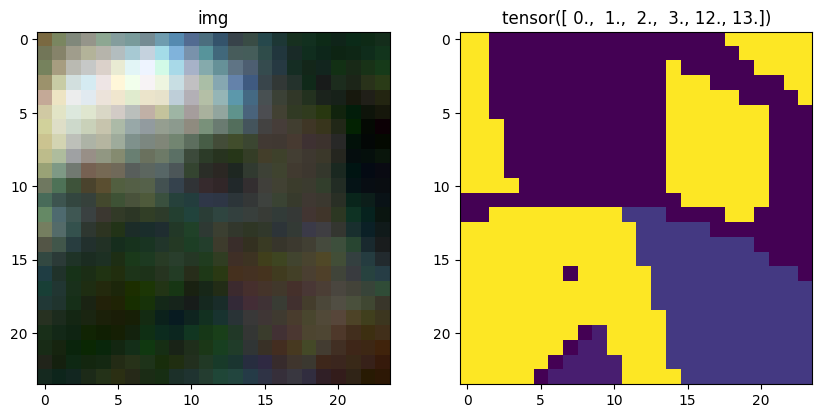

In [80]:
img, label = next(iter(dataset))

fix, axes = plt.subplots(1,2, figsize=(10,10))
axes[0].imshow(get_rgb(img[0][:,:-1,:,:].numpy()))
axes[1].imshow(label[0].numpy())

axes[0].set_title('img')
axes[1].set_title(f'{label.unique()}')

# Temporal-Spatial Vision Transformer

In [10]:
import torch.nn.functional as F

In [24]:
class TSViT(nn.Module):
    def __init__(self, max_time=60, in_channel=10, img_height=24, img_width=24, patch_size=2, embed_dim=128, num_classes=20):
        super().__init__()
        
        self.H = img_height
        self.W = img_width
        self.P = patch_size
        self.C = in_channel
        self.d = embed_dim
        self.T = max_time
        self.K = num_classes

        self.d_model = self.d
        self.nhead = 4
        self.dim_feedforward = self.d
        self.num_layers = 4

        self.N = int(self.H * self.W // self.P**2)
        # self.n = int(self.N**0.5)
        self.nh = int(self.H / self.P)
        self.nw = int(self.W / self.P)

        self.encoderLayer = nn.TransformerEncoderLayer(d_model=self.d_model, nhead=self.nhead, dim_feedforward=self.dim_feedforward)
        self.encoder = nn.TransformerEncoder(self.encoderLayer, num_layers=self.num_layers)

        self.projection = nn.Conv3d(self.C, self.d, kernel_size=(1, self.P, self.P), stride=(1, self.P, self.P))
        '''
        def __init__():
            self.linear = nn.Linear(self.C*self.P**2, self.d)
        def forward():
            x = x.view(B, T, H // P, W // P, C*P**2)
            x = self.linear(x)
        '''

        self.temporal_emb = nn.Linear(366, self.d)
        self.temporal_cls_token = nn.Parameter(torch.randn(1, self.K, self.d)) # (1, K, d)
        self.temporal_transformer = self.encoder

        self.spatial_emb = nn.Parameter(torch.randn(1, self.N, self.d)) # (1, N, d)
        # self.spatial_cls_token = nn.Parameter(torch.randn(1, self.K, self.d)) # (1, K, d)
        self.spatial_transformer = self.encoder



        self.mlp_head = nn.Sequential(
            nn.LayerNorm(self.d),
            nn.Linear(self.d, self.P**2)
            )



    def forward(self, x):

        '''
        Tekenization
        '''
        # remove the timestamps (last channel) from the input
        x_sits = x[:, :, :-1]
        B, T, C, H, W = x_sits.shape # (B, T, C, H, W)
        
        x_sits = x_sits.reshape(B, C, T, H, W) # (B, C, T, H, W)
        x_sits = self.projection(x_sits) # (B, d, T, nw, nh)
        x_sits = x_sits.view(B, self.d, T, self.nh*self.nw) # (B, d, T, N)

        # Spatial Encoding (Positional Embeddings)
        # we dont add pos embedding here, cuz we need the pure data for the temporal encoder
        # x_sits = x_sits + self.pos_emb # (B, d, T, N) 

        x_sits = x_sits.permute(0,3,2,1) # (B, N, T, d)

        '''
        Temporal Encoding
        '''
        # in the last channel lies the timestamp
        xt = x[:, :, -1, 0, 0] # (B, T, C, H, W)
        # convert to one-hot
        # xt = (xt * 365.0001).to(torch.int64)
        xt = F.one_hot(xt.to(torch.int64), num_classes=366).to(torch.float32) # (B, T, 366)
        Pt = self.temporal_emb(xt) # (B, T, d)

        '''
        Temporal Encoder: cat(Z+Pt)
        '''
        x = x_sits + Pt.unsqueeze(1) # (B, N, T, d)
        temporal_cls_token = self.temporal_cls_token # (1, 1, K, d)
        temporal_cls_token = temporal_cls_token.repeat(B, self.N, 1, 1) # (B, N, K, d)
        x = torch.cat([temporal_cls_token, x], dim=2) # (B, N, K+T, d)
        x = x.view(B*self.N, self.K + T, self.d)
        x = self.temporal_transformer(x) # (B*N, K+T, d)
        x = x.view(B, self.N, self.K + T, self.d) # (B, N, K+T, d)
        x = x[:,:,:self.K] # (B, N, K, d)
        x = x.reshape(B, self.K, self.N, self.d) # (B, K, N, d)

        '''
        Spatial Encoding
        '''
        Ps = self.spatial_emb # (1, N, d)
        Ps = Ps.unsqueeze(1) # (1, 1, N, d)
        x = x + Ps # (B, K, N, d)

        # spatial_cls_token = self.spatial_cls_token # (1, K, d)
        # spatial_cls_token = spatial_cls_token.unsqueeze(2) # (1, K, 1, d)
        # spatial_cls_token = spatial_cls_token.repeat(B, 1, 1, 1) # (B, K, 1, d)
        # x = torch.cat([spatial_cls_token, x], dim=2) # (B, K, 1+N, d)

        x = x.view(B*(self.N), self.K, self.d) # (B*(N), K, d)
        x = self.spatial_transformer(x) # (B*(N), K, d)
        x = x.view(B, self.N, self.K, self.d) # (B, (N), K, d)

        classes = x[:,0,:,:] # (B, K, d)

        # x = x[:,1:,:,:] # (B, N, K, d)

        x = x.reshape(-1, self.d)

        x = self.mlp_head(x) # (B, N, K, P*P)

        x = x.view(B, self.N, self.K, self.P, self.P) # (B, N, K, P, P)

        x = x.view(B, self.K, self.N, self.P*self.P) # (B, K, N, P*P)

        x = x.view(B, self.K, H, W) # (B, K, H, W)


        return x

### Inference

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
model = TSViT(img_width=24,img_height=24,in_channel=10,patch_size=2, embed_dim=128,max_time=60)
model.to(device)

TSViT(
  (encoderLayer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (linear1): Linear(in_features=128, out_features=128, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=128, out_features=128, bias=True)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(i

In [27]:
# x = torch.randn(2, 60, 10, 32, 32)
# t = torch.randint(0, 366, (2, 60, 1, 32, 32))
# x = torch.cat([x, t], dim=2)
# x = x.to(device)
# x.shape

### Number of Parameters

In [28]:
sum([p.numel() for p in model.parameters() if p.requires_grad == True])

571908

# Train

### Loss Function

In [32]:
class MaskedCrossEntropyLoss(torch.nn.Module):
    def __init__(self, mean=True):
        super(MaskedCrossEntropyLoss, self).__init__()
        self.mean = mean
    
    def forward(self, logits, ground_truth):
        if type(ground_truth) == torch.Tensor:
            target = ground_truth
            mask = None
        elif len(ground_truth) == 1:
            target = ground_truth[0]
            mask = None
        elif len(ground_truth) == 2:
            target, mask = ground_truth
        else:
            raise ValueError("ground_truth parameter for MaskedCrossEntropyLoss is either (target, mask) or (target)")
        
        if mask is not None:
            mask_flat = mask.reshape(-1, 1)  # (N*H*W x 1)
            nclasses = logits.shape[-1]
            logits_flat = logits.reshape(-1, logits.size(-1))  # (N*H*W x Nclasses)
            masked_logits_flat = logits_flat[mask_flat.repeat(1, nclasses)].view(-1, nclasses)
            target_flat = target.reshape(-1, 1)  # (N*H*W x 1)
            masked_target_flat = target_flat[mask_flat].unsqueeze(dim=-1).to(torch.int64)
        else:
            masked_logits_flat = logits.reshape(-1, logits.size(-1))  # (N*H*W x Nclasses)
            masked_target_flat = target.reshape(-1, 1).to(torch.int64)  # (N*H*W x 1)
        masked_log_probs_flat = torch.nn.functional.log_softmax(masked_logits_flat, dim=1)  # (N*H*W x Nclasses)
        masked_losses_flat = -torch.gather(masked_log_probs_flat, dim=1, index=masked_target_flat)  # (N*H*W x 1)
        if self.mean:
            return masked_losses_flat.mean()
        return masked_losses_flat

In [33]:
from torch import optim
import time

In [37]:
epoch = 10000
criterion = MaskedCrossEntropyLoss()
# criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
model.train()

for i in range(epoch):
  t1 = time.time()
  for img, label in dataset:
    img = img.to(device)
    label = label.to(device)

    optimizer.zero_grad()
    
    output = model(img).permute(0,2,3,1)

    loss = criterion(output, label)

    loss.backward()
    optimizer.step()
  t2 = time.time()
  print(i, loss)

0 tensor(2.2880, device='cuda:0', grad_fn=<MeanBackward0>)
1 tensor(2.3576, device='cuda:0', grad_fn=<MeanBackward0>)
2 tensor(2.3355, device='cuda:0', grad_fn=<MeanBackward0>)
3 tensor(2.2466, device='cuda:0', grad_fn=<MeanBackward0>)
4 tensor(2.3236, device='cuda:0', grad_fn=<MeanBackward0>)
5 tensor(2.2449, device='cuda:0', grad_fn=<MeanBackward0>)
6 tensor(2.2446, device='cuda:0', grad_fn=<MeanBackward0>)
7 tensor(2.2877, device='cuda:0', grad_fn=<MeanBackward0>)
8 tensor(2.2291, device='cuda:0', grad_fn=<MeanBackward0>)
9 tensor(2.3247, device='cuda:0', grad_fn=<MeanBackward0>)
10 tensor(2.2714, device='cuda:0', grad_fn=<MeanBackward0>)
11 tensor(2.2705, device='cuda:0', grad_fn=<MeanBackward0>)
12 tensor(2.3303, device='cuda:0', grad_fn=<MeanBackward0>)
13 tensor(2.3228, device='cuda:0', grad_fn=<MeanBackward0>)
14 tensor(2.2447, device='cuda:0', grad_fn=<MeanBackward0>)
15 tensor(2.2501, device='cuda:0', grad_fn=<MeanBackward0>)
16 tensor(2.2498, device='cuda:0', grad_fn=<MeanBa

KeyboardInterrupt: 